### Загружаем нужные для работы библиотеки

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Загружаем данные

In [2]:
ads_data = pd.read_csv('ads_data.csv.zip', compression = 'zip')

### Выясняем есть ли аномалии в наших данных и если есть - в какой день

In [7]:
ads_data['date'] = pd.to_datetime(ads_data.date)
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')

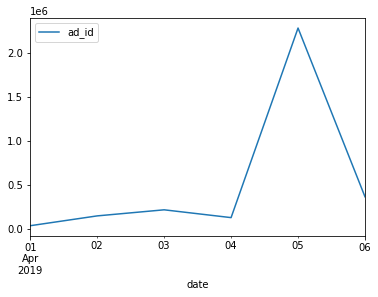

In [10]:
# групппируем все объявления по дате и считаем.

ads_data.groupby('date').agg({'ad_id':'count'}).plot()

Видим большой выброс по кол-ву объявлений 05 апреля

### Теперь выясняем всех ли событий стало больше в этот день или только определенных (click и view)

In [16]:
# число событий по дням (клики и показы)

ads_data.groupby(['date','event'], as_index = False)\
        .agg({'ad_id':'count'})\
        .pivot(index='date', columns='event', values='ad_id').reset_index()

event       date   click     view
0     2019-04-01     735    34832
1     2019-04-02    1518   145811
2     2019-04-03    1678   214851
3     2019-04-04    1517   126182
4     2019-04-05  501595  1783288
5     2019-04-06   80420   284287

Скачок кол-ва событий был и для click и для view

### далее смотрим более детально на 5 апреля

In [4]:
ads_data[ads_data.date == '2019-04-05']\
                        .groupby('ad_id')\
                        .agg({'time':'count'})\
                        .sort_values('time', ascending=False)

time
ad_id          
112583  2166611
29927     27186
44635      8268
46583      7327
44956      5656
...         ...
46433        17
21405        16
46024        16
113867       15
111067       14

[131 rows x 1 columns]

### Видим что на это число сильно выбивается одно объявление с id = 112583

In [5]:
ad_id = 112583

In [7]:
# отбираем информацию для этого конкретного id

ads_data.query('ad_id == @ad_id').groupby('date').agg({'time':'count'})

time
date               
2019-04-05  2166611
2019-04-06   348613

In [8]:
ads_data.query('ad_id == @ad_id').head(1)

ad_id        time event        date ad_cost_type  has_video  \
527124  112583  1554480636  view  2019-04-05          CPM          0   

        client_union_id  campaign_union_id platform  ad_cost  \
527124           111818             112260      web    199.4   

        target_audience_count  user_id  
527124                 239408     4355

Вывод: наибольший вклад в аномалию показов 5 апреля внесло объявление с id = 112583

### Теперь найдем топ10 объявлений по ctr

In [10]:
ads_ctr = ads_data.groupby(['ad_id','event'], as_index = False)\
        .agg({'time':'count'})\
        .pivot(index='ad_id', columns='event', values='time').reset_index()

# создаем 2 новые колонки: ctr и ctr в процентах
ads_ctr = ads_ctr.assign(ctr = ads_ctr.click / ads_ctr.view, ctr_per = 100 * ads_ctr.click / ads_ctr.view)

ads_ctr.sort_values('ctr', ascending=False).head(10)

event   ad_id     click       view       ctr    ctr_per
289    112583  580436.0  1934788.0  0.300000  29.999979
324    119450     258.0     1254.0  0.205742  20.574163
125     38575      43.0      257.0  0.167315  16.731518
144     40968      29.0      217.0  0.133641  13.364055
207     45642      42.0      344.0  0.122093  12.209302
283    110924      11.0       95.0  0.115789  11.578947
194     45043      28.0      245.0  0.114286  11.428571
96      35034     112.0      997.0  0.112337  11.233701
5        4585      53.0      476.0  0.111345  11.134454
328    120347     236.0     2168.0  0.108856  10.885609

### теперь посмотрим на средний и медианный ctr

In [15]:
print('средний ctr: ' + str(round(ads_ctr.ctr.mean(),2)))
print('медианный ctr: ' + str(round(ads_ctr.ctr.median(),2)))

средний ctr: 0.02
медианный ctr: 0.01


они различаются в 2 раза

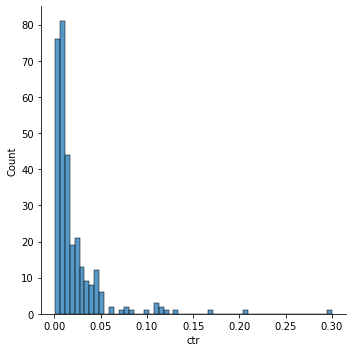

In [16]:
# распределение ctr

sns.displot(ads_ctr.ctr, kde = False)

### Теперь проверим наши данные на баги

находим объявления с кликами, но без показов

In [20]:
ads_ids_bug = ads_ctr.query("(click == click) & (view != view)").ad_id
ads_ids_bug

50      25665
77      30381
150     41424
161     42241
213     45866
219     46363
224     46544
294    113348
331    120444
Name: ad_id, dtype: int64

теперь смотрим кол-во объявлений с ошибками в разбивке по платформам

In [23]:
ads_data_bug_df = ads_data[ads_data.ad_id.isin(ads_ids_bug)]\
                    .groupby('platform', as_index = False)\
                    .agg({'ad_id' : 'count'})\
                    .rename(columns={'ad_id':'ads_count_bug'})\
                    .sort_values('ads_count_bug')
ads_data_bug_df

platform  ads_count_bug
2      web             53
1      ios             92
0  android            141

всего объявлений в разбивке по платформам

In [25]:
ads_data_all_df = ads_data.groupby('platform', as_index = False)\
                    .agg({'ad_id' : 'count'})\
                    .rename(columns={'ad_id':'ads_count'})\
                    .sort_values('ads_count')
ads_data_all_df

platform  ads_count
2      web     635425
1      ios     953078
0  android    1588211

и выясняем процент багов для каждой платформы

In [46]:
# соединяем датафреймы
ads_data_merged = ads_data_all_df.merge(ads_data_bug_df, on='platform')

# вычисляем процент ошибок по платформе

for i, row in ads_data_merged.iterrows():
    bug_percent = round(100 * row['ads_count_bug'] / row['ads_count'],5)
    print(f'Процент багов на платформе {row.platform} равен {bug_percent} %')

Процент багов на платформе web равен 0.00834 %
Процент багов на платформе ios равен 0.00965 %
Процент багов на платформе android равен 0.00888 %


### Теперь найдем объявления по которым сначала был клик, а потом показ

In [64]:
ads_clickbefore = ads_data.groupby(['ad_id','event'], as_index = False)\
        .agg({'time':'min'})\
        .pivot(index='ad_id', columns='event', values='time')\
        .reset_index()\
        .query('click < view')

print(f'Id объявлений, по которым клик был раньше показа: {ads_clickbefore.ad_id.tolist()}')

Id объявлений, по которым клик был раньше показа: [16548, 30939, 40464, 42007, 44543, 45436, 119450]


### Теперь считаем заработок

In [48]:
# Стоимость объявлений типа CPC

cpc_sum = ads_data[(ads_data.ad_cost_type == 'CPC') & (ads_data.event == 'click')].ad_cost.sum()
print(f'На объявлениях CPC заработали: {cpc_sum}')

На объявлениях CPC заработали: 84810.0


In [55]:
# Стоимость объявлений типа CPM

cpm_sum = ads_data[(ads_data.ad_cost_type == 'CPM') & (ads_data.event == 'view')].ad_cost.sum() / 1000
print(f'На объявлениях CPM заработали: {round(cpm_sum,2)}')

На объявлениях CPM заработали: 497090.68


In [56]:
# Всего заработано денег за все время:

print(f'Всего заработано денег за все время: {round(cpc_sum + cpm_sum,2)}')

Всего заработано денег за все время: 581900.68
